In [1]:
import gymnasium as gym
import numpy as np
import tensorflow as tf
import matplotlib.pyplot as plt
import numba as nb
import cv2

In [2]:
# Set up environment
env = gym.make('CarRacing-v2', continuous=False)
env.reset()

(array([[[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        ...,
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]],
 
        [[0, 0, 0],
         [0, 0, 0],
         [0, 0, 0],
         ...,
         [0, 0, 0],
         [0, 0, 0],
         [0, 0, 0]]], dtype=uint8),
 {})

# Pre-process

In [3]:
def crop(img):
    img = img[:84, 6:90] # CarRacing-v2-specific cropping
    # img = cv2.resize(img, dsize=(84, 84)) # or you can simply use rescaling
    
    # img = cv2.cvtColor(img, cv2.COLOR_RGB2GRAY) / 255.0
    return img

@nb.njit(fastmath=True)
def rgb_to_grey(img):
    """
    Convert an RGB image to greyscale using the weighted method.
    """
    num_rows, num_cols, _ = img.shape
    grey_img = np.empty((num_rows, num_cols), dtype=np.uint8)
    for i, row in enumerate(img):
        for j, rgb_pixel in enumerate(row):
            # Compute weighted sum of RGB channels
            grey_img[i, j] = 0.2989 * rgb_pixel[0] + 0.5870 * rgb_pixel[1] + 0.1140 * rgb_pixel[2]

    return grey_img

In [4]:
class ImageEnv(gym.Wrapper):
    def __init__(
        self,
        env,
        skip_frames=4,
        stack_frames=4,
        initial_no_op=50,
        **kwargs
    ):
        super(ImageEnv, self).__init__(env, **kwargs)
        self.initial_no_op = initial_no_op
        self.skip_frames = skip_frames
        self.stack_frames = stack_frames

    
    def reset(self):
        # reset the original environment
        s, info = self.env.reset()

        # Do nothing for the next `self.initial_no_op` steps
        for i in range(self.initial_no_op):
            s, r, terminated, truncated, info = self.env.step(0)

        # crop image
        s = crop(s)
        s = rgb_to_grey(s)
        

        # initial observation is simply a copy of the frame 's'
        self.stacked_state = np.tile(s, (self.stack_frames, 1, 1))
        return self.stacked_state, info
    
    def step(self, action):
        # Take an action for self.skip_frames steps
        reward = 0
        for _ in range(self.skip_frames):
            s, r, terminated, truncated, info = self.env.step(action)
            reward += r
            if terminated or truncated:
                break

        s = crop(s)
        s = rgb_to_grey(s)

        # push the current frame 's' at the end of self.stacked_state
        self.stacked_state = np.concatenate((self.stacked_state[1:], s[np.newaxis]), axis=0)

        return self.stacked_state, reward, terminated, truncated, info

The shape of an observation:  (4, 84, 84)


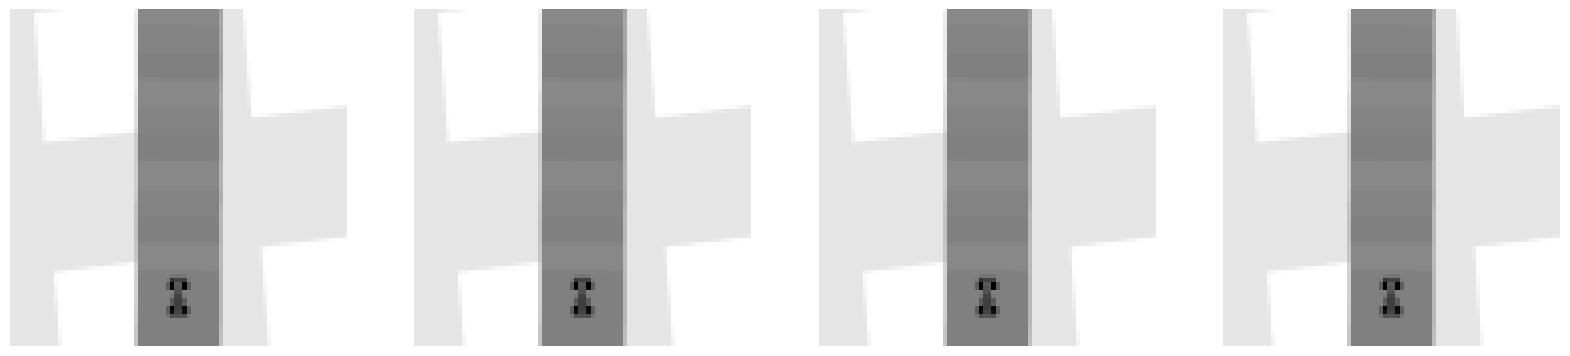

In [5]:
env = gym.make('CarRacing-v2', continuous=False)
env = ImageEnv(env)

s, _ = env.reset()
print("The shape of an observation: ", s.shape)

fig, axes = plt.subplots(1, 4, figsize=(20, 5))
for i in range(4):
    axes[i].imshow(s[i], cmap='gray')
    axes[i].axis('off')
plt.show()

# Creating Q-Network

In [6]:
class CNNActionValue(tf.keras.Model):
    def __init__(self, state_dim, action_dim, activation=tf.nn.relu):
        super(CNNActionValue, self).__init__()
        self.conv1 = tf.keras.layers.Conv2D(16, kernel_size=8, strides=4, input_shape=state_dim) # [N, 4, 84, 84] -> [N, 16, 20, 20]
        self.conv2 = tf.keras.layers.Conv2D(32, kernel_size=4, strides=2) # [N, 16, 20, 20] -> [N, 32, 9, 9]
        self.flatten = tf.keras.layers.Flatten()
        self.fc1 = tf.keras.layers.Dense(256, activation=activation)
        self.fc2 = tf.keras.layers.Dense(action_dim)

    def call(self, x):
        x = tf.nn.relu(self.conv1(x))
        x = tf.nn.relu(self.conv2(x))
        x = self.flatten(x)
        x = self.fc1(x)
        x = self.fc2(x)
        return x

In [7]:
# Step 1: Generate some random input data
input_data = np.random.rand(32, 84, 84, 4).astype(np.float32)

input_data = tf.convert_to_tensor(input_data)

# Step 2: Instantiate the model
model = CNNActionValue(state_dim=(4, 84, 84), action_dim=10)

# Step 3: Test the model's output
output = model.call(input_data)
assert output.shape == (32, 10), f"Expected output shape (32, 10), but got {output.shape}"

# Step 4: Test the model's differentiability
with tf.GradientTape() as tape:
    tape.watch(input_data)
    output = model.call(input_data)
grads = tape.gradient(output, input_data)
assert grads.shape == input_data.shape, f"Expected gradient shape {input_data.shape}, but got {grads.shape}"

# Step 5: Update the model parameters
optimizer = tf.keras.optimizers.Adam(learning_rate=1e-3)
for i in range(10):
    with tf.GradientTape() as tape:
        tape.watch(model.trainable_variables)
        output = model.call(input_data)
        loss = tf.reduce_mean(output)
    grads = tape.gradient(loss, model.trainable_variables)
    optimizer.apply_gradients(zip(grads, model.trainable_variables))
    
    # Step 6: Repeat the process for a few iterations
    print(f"Iteration {i+1}: Loss={loss.numpy():.4f}")

Iteration 1: Loss=-0.0166
Iteration 2: Loss=-0.5778
Iteration 3: Loss=-1.6386
Iteration 4: Loss=-3.6169
Iteration 5: Loss=-7.0159
Iteration 6: Loss=-12.4997
Iteration 7: Loss=-20.8860
Iteration 8: Loss=-33.1798
Iteration 9: Loss=-50.5604
Iteration 10: Loss=-74.4021


# Replay buffer

In [8]:
class ReplayBuffer:
    def __init__(self, state_dim, action_dim, max_size=int(1e5)):
        self.s = np.zeros((max_size, *state_dim), dtype=np.float32)
        self.a = np.zeros((max_size, *action_dim), dtype=np.int64)
        self.r = np.zeros((max_size, 1), dtype=np.float32)
        self.s_prime = np.zeros((max_size, *state_dim), dtype=np.float32)
        self.terminated = np.zeros((max_size, 1), dtype=np.float32)

        self.ptr = 0
        self.size = 0
        self.max_size = max_size

    def update(self, s, a, r, s_prime, terminated):
        self.s[self.ptr] = s
        self.a[self.ptr] = a
        self.r[self.ptr] = r
        self.s_prime[self.ptr] = s_prime
        self.terminated[self.ptr] = terminated
        
        self.ptr = (self.ptr + 1) % self.max_size
        self.size = min(self.size + 1, self.max_size)
        
    def sample(self, batch_size):
        ind = np.random.randint(0, self.size, batch_size)
        return (
            tf.constant(self.s[ind], dtype=tf.float32),
            tf.constant(self.a[ind], dtype=tf.int32),
            tf.constant(self.r[ind], dtype=tf.float32),
            tf.constant(self.s_prime[ind], dtype=tf.float32),
            tf.constant(self.terminated[ind], dtype=tf.float32),
        )

# DQN Agent

In [9]:
class DQN:
    def __init__(
        self,
        state_dim,
        action_dim,
        learning_rate=0.00025,
        epsilon=1.0,
        epsilon_min=0.1,
        gamma=0.99,
        batch_size=32,
        warmup_steps=5000,
        buffer_size=int(1e5),
        target_update_interval=10000,
    ):
        self.action_dim = action_dim
        self.epsilon = epsilon
        self.gamma = gamma
        self.batch_size = batch_size
        self.warmup_steps = warmup_steps
        self.target_update_interval = target_update_interval

        self.network = CNNActionValue(state_dim, action_dim)
        self.target_network = CNNActionValue(state_dim, action_dim)
        self.target_network.set_weights(self.network.get_weights())
        self.optimizer = tf.keras.optimizers.RMSprop(learning_rate)

        self.buffer = ReplayBuffer(state_dim, (1, ), buffer_size)
        self.device = tf.device('gpu' if tf.test.is_built_with_cuda() else 'cpu')

        self.total_steps = 0
        self.epsilon_decay = (epsilon - epsilon_min) / 1e6

    # @tf.function
    # def act(self, x, training=True):
    #     self.network.trainable(training)
    #     if training and ((tf.random.uniform([]) < self.epsilon) or (self.total_steps < self.warmup_steps)):
    #         a = tf.random.uniform([], maxval=self.action_dim, dtype=tf.int64)
    #         # np.random.randint(self.action_dim)
    #     else:
    #         x = tf.expand_dims(x, axis=0)
    #         q = self.network(x)
    #         a = tf.argmax(q, axis=-1)
    #     return a.numpy()[0]

    @tf.function
    def act(self, x, training=True):
        self.network.trainable = training
        if training and ((np.random.rand() < self.epsilon) or (self.total_steps < self.warmup_steps)):
            a = np.random.randint(0, self.action_dim)
        else:
            x = tf.expand_dims(tf.convert_to_tensor(x, dtype=tf.float32), axis=0)
            q = self.network(x)
            a = tf.argmax(q, axis=1).numpy()[0]
        return a
    
     # def act(self, state, training=True):
    #     if training and np.random.rand() < self.epsilon:
    #         # Select a random action with probability epsilon
    #         action = np.random.randint(self.action_dim)
    #     else:
    #         # Select the action with the highest Q-value
    #         state = tf.expand_dims(state, axis=0)
    #         q_values = self.network(state, training=False)
    #         action = tf.argmax(q_values, axis=1).numpy()[0]
    #     return action
    
    
    # def act(self, x, training=True):
    #     if not training:
    #         tf.keras.backend.set_learning_phase(False)
    #     else:
    #         tf.keras.backend.set_learning_phase(True)

    #     if training and ((np.random.rand() < self.epsilon) or (self.total_steps < self.warmup_steps)):
    #         a = np.random.randint(0, self.action_dim)
    #     else:
    #         x = tf.expand_dims(tf.convert_to_tensor(x, dtype=tf.float32), 0)
    #         q = self.network(x, training=training)
    #         a = tf.argmax(q[0]).numpy()
    #     return a

    
    
    @tf.function
    def learn(self):
        s, a, r, s_prime, terminated = self.buffer.sample(self.batch_size)
        s = tf.convert_to_tensor(s)
        a = tf.convert_to_tensor(a)
        r = tf.convert_to_tensor(r)
        s_prime = tf.convert_to_tensor(s_prime)
        terminated = tf.convert_to_tensor(terminated)

        with tf.GradientTape() as tape:
            next_q = self.target_network(s_prime)
            td_target = r + (1. - terminated) * self.gamma * tf.reduce_max(next_q, axis=-1, keepdims=True)
            q_values = tf.gather_nd(self.network(s), tf.stack((tf.range(a.shape[0]), a[:, 0]), axis=1))
            loss = tf.reduce_mean(tf.square(q_values - tf.stop_gradient(td_target)))

        gradients = tape.gradient(loss, self.network.trainable_variables)
        self.optimizer.apply_gradients(zip(gradients, self.network.trainable_variables))

        result = {
            'total_steps': self.total_steps,
            'value_loss': loss.numpy(),
        }
        return result
    
    def process(self, transition):
        result = {}
        self.total_steps += 1
        self.buffer.update(*transition)

        if self.total_steps > self.warmup_steps:
            result = self.learn()

        if self.total_steps % self.target_update_interval == 0:
            self.target_network.set_weights(self.network.get_weights())
        self.epsilon -= self.epsilon_decay
        return result

In [10]:
env = gym.make('CarRacing-v2', continuous=False)
env = ImageEnv(env)

max_steps = int(250000)
eval_interval = 10000
state_dim = (4, 84, 84) 
action_dim = env.action_space.n

agent = DQN(state_dim, action_dim)

In [11]:
def evaluate(n_evals=5):
    eval_env = gym.make('CarRacing-v2', continuous=False)
    eval_env = ImageEnv(eval_env)
    
    scores = 0
    for i in range(n_evals):
        (s, _), done, ret = eval_env.reset(), False, 0
        while not done:
            a = agent.act(s, training=False)
            s_prime, r, terminated, truncated, info = eval_env.step(a)
            s = s_prime
            ret += r
            done = terminated or truncated
        scores += ret
    return np.round(scores / n_evals, 4)

In [12]:
# from IPython.display import clear_output

# history = {'Step': [], 'AvgReturn': []}

# (s, _) = env.reset()
# while True:
#     a = agent.act(s)
#     s_prime, r, terminated, truncated, info = env.step(a)
#     result = agent.process((s, a, r, s_prime, terminated))  # You can track q-losses over training from `result` variable.
    
#     s = s_prime
#     if terminated or truncated:
#         s, _ = env.reset()
        
#     if agent.total_steps % eval_interval == 0:
#         ret = evaluate()
#         history['Step'].append(agent.total_steps)
#         history['AvgReturn'].append(ret)
        
#         clear_output()
#         plt.figure(figsize=(8, 5))
#         plt.plot(history['Step'], history['AvgReturn'], 'r-')
#         plt.xlabel('Step', fontsize=16)
#         plt.ylabel('AvgReturn', fontsize=16)
#         plt.xticks(fontsize=14)
#         plt.yticks(fontsize=14)
#         plt.grid(axis='y')
#         plt.show()
        
#         agent.network.save_weights('dqn.h5')
    
#     if agent.total_steps > max_steps:
#         break

# Evaluation

In [13]:
eval_env = gym.make('CarRacing-v2', continuous=False, render_mode='rgb_array')
eval_env = ImageEnv(eval_env)

frames = []
scores = 0
(s, _), done, ret = eval_env.reset(), False, 0
while not done:
    frames.append(eval_env.render())
    s = s.astype(np.float32)
    a = agent.act(s, training=False)
    s_prime, r, terminated, truncated, info = eval_env.step(a)
    s = s_prime
    ret += r
    done = terminated or truncated
scores += ret

ValueError: in user code:

    File "C:\Users\sebsj\AppData\Local\Temp\ipykernel_22668\2188534290.py", line 52, in act  *
        q = self.network(x)
    File "c:\Users\sebsj\anaconda3\envs\tensorflow\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler  **
        raise e.with_traceback(filtered_tb) from None
    File "C:\Users\sebsj\AppData\Local\Temp\__autograph_generated_filemnxwfn3k.py", line 10, in tf__call
        x = ag__.converted_call(ag__.ld(tf).nn.relu, (ag__.converted_call(ag__.ld(self).conv1, (ag__.ld(x),), None, fscope),), None, fscope)

    ValueError: Exception encountered when calling layer 'cnn_action_value_1' (type CNNActionValue).
    
    in user code:
    
        File "C:\Users\sebsj\AppData\Local\Temp\ipykernel_22668\1781783688.py", line 11, in call  *
            x = tf.nn.relu(self.conv1(x))
        File "c:\Users\sebsj\anaconda3\envs\tensorflow\lib\site-packages\keras\utils\traceback_utils.py", line 70, in error_handler  **
            raise e.with_traceback(filtered_tb) from None
    
        ValueError: Exception encountered when calling layer 'conv2d_2' (type Conv2D).
        
        Negative dimension size caused by subtracting 8 from 4 for '{{node cnn_action_value_1/conv2d_2/Conv2D}} = Conv2D[T=DT_FLOAT, data_format="NHWC", dilations=[1, 1, 1, 1], explicit_paddings=[], padding="VALID", strides=[1, 4, 4, 1], use_cudnn_on_gpu=true](ExpandDims, cnn_action_value_1/conv2d_2/Conv2D/ReadVariableOp)' with input shapes: [1,4,84,84], [8,8,84,16].
        
        Call arguments received by layer 'conv2d_2' (type Conv2D):
          • inputs=tf.Tensor(shape=(1, 4, 84, 84), dtype=float32)
    
    
    Call arguments received by layer 'cnn_action_value_1' (type CNNActionValue):
      • x=tf.Tensor(shape=(1, 4, 84, 84), dtype=float32)


In [14]:
def animate(imgs, video_name, _return=True):
    import cv2
    import os
    import string
    import random
    
    if video_name is None:
        video_name = ''.join(random.choice(string.ascii_letters) for i in range(18)) + '.webm'
    height, width, layers = imgs[0].shape
    fourcc = cv2.VideoWriter_fourcc(*'VP90')
    video = cv2.VideoWriter(video_name, fourcc, 10, (width, height))
    
    for img in imgs:
        img = cv2.cvtColor(img, cv2.COLOR_BGR2RGB)
        video.write(img)
    video.release()
    if _return:
        from IPython.display import Video
        return Video(video_name)

In [15]:
animate(frames)

TypeError: animate() missing 1 required positional argument: 'video_name'